In [9]:
# ### task
#  - считывать картинку + ближайшую точку на соотв disparity map

# - выделить маску

# ### Data description

# Ideas: exclude road

### Imports

In [191]:
import cv2
import glob
import os
import sys
import numpy as np
import json
from collections import defaultdict


from matplotlib import pyplot as plt
%matplotlib inline


In [192]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Reading

In [134]:
# path_data = '/home/anastasia/obj_detection/data/cityscapes/disparity'
# print os.path.abspath(path_data)

In [237]:
# paths 
cityscapesPath = os.path.normpath(os.path.join(os.path.dirname('__file__'), '..', 'data/cityscapes'))
img_dir = 'leftImg8bit'
path_left_imgs = os.path.normpath(os.path.join(cityscapesPath,img_dir))

# default dictionary of cities
cities = defaultdict(list)
modes = ['train','test','val']
for mode in modes:
    for (dirpath, dirnames, filenames) in os.walk(path_left_imgs+'/'+mode):
        cities[mode] = dirnames 
        break
        
mode = 'train'
city = 'zurich'

# returns list of paths to imgs for this city
def ReadImgPaths(mode=mode, city=city):
    
    # absolute path to the directory with images
    path_imgs_dir = os.path.normpath(os.path.join(cityscapesPath,img_dir, mode, city))
    # list of absolute paths to images
    path_imgs = glob.glob(path_imgs_dir + '/*.png')
    path_imgs.sort()
    
    print 'ReadImgPaths.','%s %s: number of images is' %(mode,city), len(imgs)
    
    return path_imgs


# returns list of paths to disparity imgs for this city
def ReadDispPaths(mode=mode, city=city):
    
    # absolute path to the directory with disparities
    path_disp_dir = os.path.normpath(os.path.join(cityscapesPath,'disparity', mode, city))
    # list of absolute paths to disparities
    path_disp_imgs = glob.glob(path_disp_dir + '/*.png')
    path_disp_imgs.sort()
    
    print 'ReadDispPaths.', '%s %s: number of disparity images is' %(mode,city), len(disp_imgs)
    
    return path_disp_imgs


# returns list of paths to annotations for this city
def ReadAnnoPaths(mode=mode, city=city):
      
    # absolute path to the directory with annotations
    path_anno_dir = os.path.normpath(os.path.join(cityscapesPath,'gtFine', mode, city))
    # list of absolute paths to annotations
    path_anno = glob.glob(path_anno_dir + '/*.json')
    path_anno.sort()
    
    print 'ReadAnnoPaths.', '%s %s: number of annotations is' %(mode,city), len(disp_imgs)
    
    return path_anno
    
    
def ReadAnnoImgPath(mode=mode, city=city):
    
        # absolute path to the directory with annotations
    path_anno_dir = os.path.normpath(os.path.join(cityscapesPath,'gtFine', mode, city))
    # list of absolute paths to annotations
    path_anno = glob.glob(path_anno_dir + '/*color.png')
    path_anno.sort()
    
    print 'ReadAnnoPaths.', '%s %s: number of annotations is' %(mode,city), len(disp_imgs)
    
    return path_anno_imgs

    
# find a disparity for the image path
def DispForImg(img_path, mode=mode, city=city):
    
    path_disp_dir = os.path.normpath(os.path.join(cityscapesPath,'disparity', mode, city))
    
    # take a tail of img path
    img_name = os.path.split(img_path)[1]
    # remove extention
    img_name = os.path.splitext(img_name)[0]
    # take img number
    img_number = img_name[:-len(img_dir)]
    # abs path to the corresponded disparity
    path_disp_img = glob.glob(path_disp_dir +'/'+ str(img_number)+'*')[0]
    
    return path_disp_img


# find the annotation for the image path
def AnnoForImg(img_path, mode=mode, city=city):
    
    path_anno_dir = os.path.normpath(os.path.join(cityscapesPath,'gtFine', mode, city))
    
    # take a tail of img path
    img_name = os.path.split(img_path)[1]
    # remove extention
    img_name = os.path.splitext(img_name)[0]
    # take img number
    img_number = img_name[:-len(img_dir)]
    # abs path to the corresponded annotation
    path_anno = glob.glob(path_anno_dir +'/'+ str(img_number)+'*'+'.json')[0]
    
    return path_anno

# extract the polygons correspond to the label
def ExtractPolygon(json_file, label='road'):
    
    with open(json_file) as anno:    
        data = json.load(anno)
    polygon = [d['polygon'] for d in data["objects"] if d['label'] == label][0]  
    
    return np.array(polygon)


# make disparitis = 0 for the road points
# TODO DEBUG
def ExcludeRoadDisp(img, polygon):
    '''
    @param polygon -- list of points coordinates
    '''
    
    mask = np.ones(img.shape, dtype=np.uint8)*255
    roi_corners = np.array(polygon, dtype=np.int32)
    # fill the ROI so it doesn't get wiped out when the mask is applied
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (0,)*channel_count
    cv2.fillPoly(mask, roi_corners, ignore_mask_color)
    
    # apply the mask
    masked_image = cv2.bitwise_and(img, mask)
    
    pass

# calculate max disparity excluding road points
def MaxDispValue(path_disp_img, mode=mode, city=city):

    disp = cv2.imread(path_disp_img, -1)
    
    return np.max(disp[np.nonzero(disp)])


def CropRoI(img_path):
    
    # original image
    # -1 loads as-is so if it will be 3 or 4 channel as the original
    img = cv2.imread(img_path, -1)
    
    y_shape,x_shape,_ = img.shape
    
    X = np.zeros(4)
    Y = np.zeros(4)
    
    #top left
    X[0] = x_shape // 3
    Y[0] = y_shape // 3
    
    #bottom left
    X[1] = 0
    Y[1] = y_shape
    
    #bottom right
    X[2] = x_shape
    Y[2] = Y[1]
    
    #top right
    X[3] = 9 * x_shape // 10
    Y[3] = Y[0]
    
    # mask defaulting to black for 3-channel and transparent for 4-channel
    # (of course replace corners with yours)
    mask = np.zeros(img.shape, dtype=np.uint8)
    roi_corners = np.array([zip(X, Y)], dtype=np.int32)
    # fill the ROI so it doesn't get wiped out when the mask is applied
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,)*channel_count
    cv2.fillPoly(mask, roi_corners, ignore_mask_color)

    # apply the mask
    masked_image = cv2.bitwise_and(img, mask)

    # save the result
    #cv2.imwrite('image_masked.png', masked_image)
    
    return masked_image



def Plot(img):
    plt.figure(figsize = (10,5))
    plt.imshow(img)

## Test

In [230]:
imgs = ReadImgPaths()
disp_imgs = ReadDispPaths()
annos = ReadAnnoPaths()
anno_imgs = Read
print disp_imgs[0]

filename = os.path.split(imgs[0])[1]
name = os.path.splitext(filename)[0][:-len(img_dir)]
print name

disp = cv2.imread(DispForImg(imgs[0]))
print np.max(disp[np.nonzero(disp)])

ReadImgPaths. train zurich: number of images is 122
ReadDispPaths. train zurich: number of disparity images is 122
ReadAnnoPaths. train zurich: number of annotations is 122
../data/cityscapes/disparity/train/zurich/zurich_000000_000019_disparity.png
zurich_000000_000019_
116


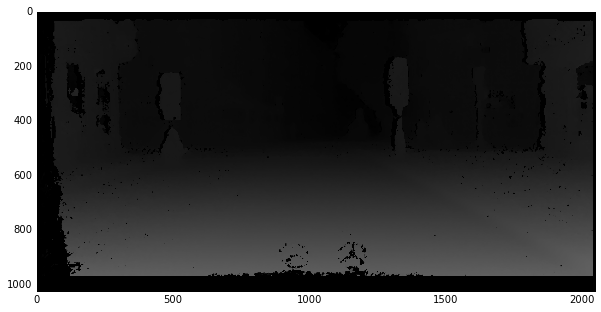

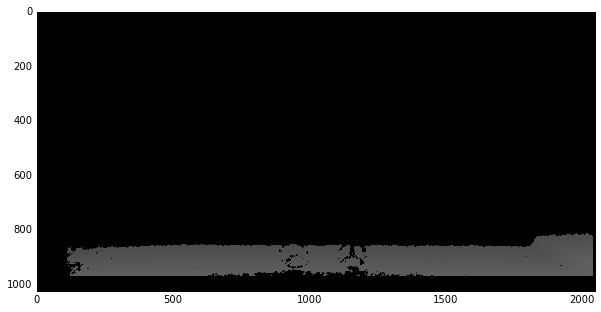

In [226]:
# good example nmb_image = 41, 12

nmb_img = np.random.randint(0,len(disp_imgs))
# print 'image index in list imgs:', nmb_img

# print disp.shape
# print disp_imgs[nmb_img]
# print imgs[nmb_img]

disp = cv2.imread(disp_imgs[nmb_img])
img = cv2.imread(imgs[nmb_img])
img_path = imgs[nmb_img]

# print 'max disparity:', disp.max()
Plot(disp)

''' In percentile '''
disp_perc = disp.copy()
disp_perc[disp < np.percentile(disp, 90)] = 0
# print disp.max()
Plot(disp_perc)

## Disparities in the percentile

98


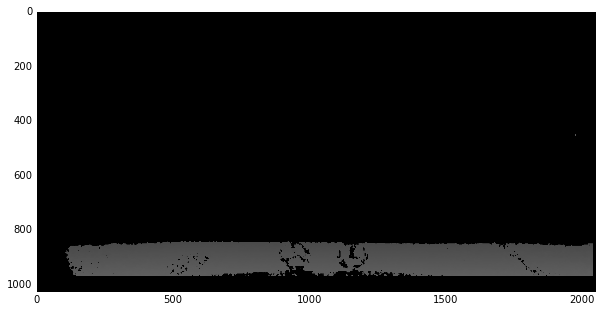

In [151]:
disp_perc = disp.copy()
disp_perc[disp < np.percentile(disp, 90)] = 0
print disp.max()
Plot(disp_perc)

## Image's pixels correspondes to disparity in the percentile

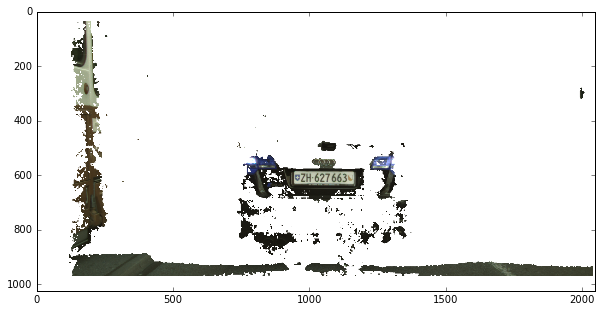

In [148]:
img_perc = img.copy()
img_perc[disp < np.percentile(disp, 90)] = 255
Plot(img_perc)

## RoI, Cropped image

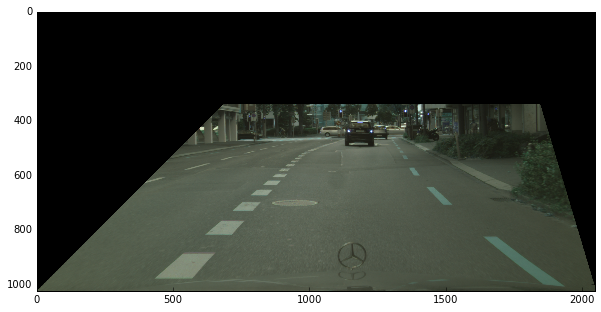

In [150]:
Plot(CropRoI(img_path))

## Exluding Road

(1024, 2048, 3)


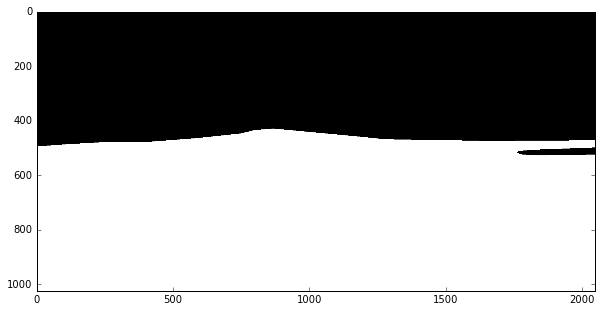

In [287]:
# original image
# -1 loads as-is so if it will be 3 or 4 channel as the original
img = cv2.imread(disp_imgs[i])
print img.shape

y_shape,x_shape,_ = img.shape

X = np.zeros(4)
Y = np.zeros(4)

# #top left
# X[0] = x_shape // 3
# Y[0] = y_shape // 3

# #bottom left
# X[1] = 0
# Y[1] = y_shape

# #bottom right
# X[2] = x_shape
# Y[2] = Y[1]

# #top right
# X[3] = 9 * x_shape // 10
# Y[3] = Y[0]

polygon = ExtractPolygon(annos[0])

# mask defaulting to black for 3-channel and transparent for 4-channel
# (of course replace corners with yours)
mask = np.zeros(img.shape, dtype=np.uint8)
roi_corners = np.array([polygon], dtype=np.int32)
# fill the ROI so it doesn't get wiped out when the mask is applied
channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
ignore_mask_color = (255,)*channel_count
cv2.fillPoly(mask, roi_corners, ignore_mask_color)

Plot(mask)

In [274]:
[zip(X, Y)]

[[(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]]

In [281]:
[polygon.tolist()[:4]]

[[[0, 1024], [2048, 1024], [2048, 525], [1830, 528]]]

In [312]:
polygon

array([[2049, 1024],
       [2047,  407],
       [2047,  875],
       [2048,  397],
       [   0,  573],
       [   1, 1023],
       [   4, 1023],
       [2047, 1022]])

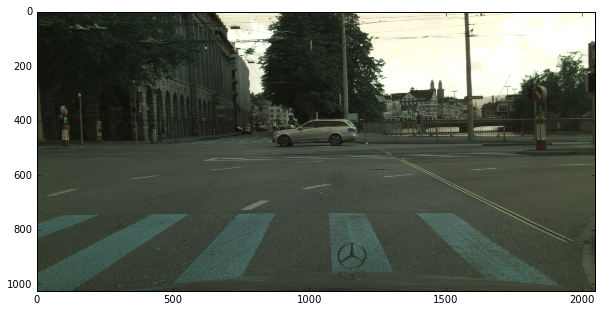

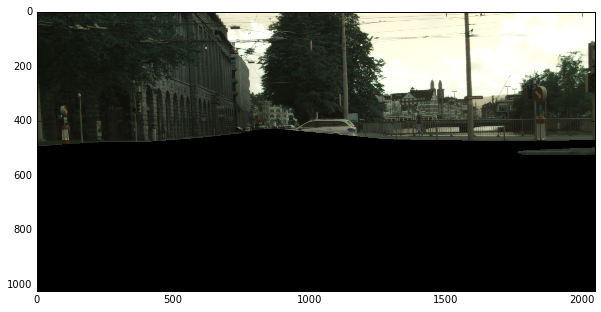

In [314]:
i = 0
img = cv2.imread(imgs[i])
polygon = ExtractPolygon(annos[i])
# print polygon
Plot(cv2.imread(imgs[i]))

# mask defaulting to black for 3-channel and transparent for 4-channel
# (of course replace corners with yours)
mask = np.ones(img.shape[:2], dtype=np.uint8)
roi_corners = np.array([polygon], dtype=np.int32)
# fill the ROI so it doesn't get wiped out when the mask is applied
channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
ignore_mask_color = (0,)*channel_count
cv2.fillPoly(mask, roi_corners, ignore_mask_color)

# apply the mask
masked_image = cv2.bitwise_and(img, img, mask=mask)
Plot(masked_image)

## Histogram of max disparties for this city

In [46]:
max_disps = []
print len(disp_imgs)
for i in range (len(disp_imgs)):
    max_disps.append(MaxDispValue(disp_imgs[i]))


221


(array([   1.,    1.,    1.,    0.,    0.,    1.,    2.,    0.,    1.,
           1.,    1.,    2.,    4.,    3.,    1.,    3.,    4.,    5.,
           9.,    7.,   13.,    8.,   15.,   16.,  122.]),
 array([  97.  ,   98.16,   99.32,  100.48,  101.64,  102.8 ,  103.96,
         105.12,  106.28,  107.44,  108.6 ,  109.76,  110.92,  112.08,
         113.24,  114.4 ,  115.56,  116.72,  117.88,  119.04,  120.2 ,
         121.36,  122.52,  123.68,  124.84,  126.  ]),
 <a list of 25 Patch objects>)

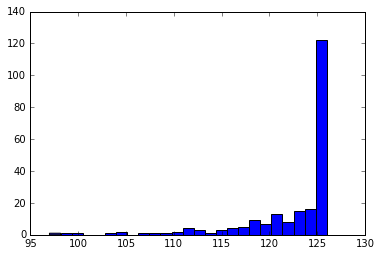

In [47]:
plt.hist(max_disps, bins=25)